# Notebook Introduction
Within this notebook i will be attempting to analyze a dataset storing a multitude of companies quarterly earning release dates, dividend declaration dates, and dividend expiration dates in order to understand the general flow of companies financial releases. The typical expected pattern is Quarter End Date, followed by an Earnings Declaration, followed by an Earnings Announcement, Followed by a Dividend Decleration, followed by a Dividend Expiration. Understanding how exactly this release schedule works, and the expected time between announcements is crucial to options trading as earning announcements lead to a massive increase of market volatility, by analyzing past data i hope to gain a deeper understanding of when to expect increased market volatility in the future.

In [83]:
# necessary import statements 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy.stats import norm

# Step One: Building and cleaning the data
before we proceed to analyze and make predictions from our dataset we must clean our dataset to our liking. This will consist of multiple key steps
* importing our dataset and getting a general feel for the information it stores and how it stores it by looking at its statistics, as well as its datatypes
* Combining earning declarations columns by choosing an appropriate value from "EarningsDeclarationDate" or "EarningsDeclarationDateWSH"
* marking each datapoint with its appropriate fiscal quarter (as we may want to track differences between announcements in each quarter)
* removing remaining null data
We begin by importing our data from a csv file to a pandas dataframe and taking a look at its general statistics and datatypes 

In [37]:
#TODO: DECIDE WHETHER TO FIND FOLLOWING DATA 
"""
marking each datapoint with its appropriate fiscal quarter (as we may want to track differences between announcements in each quarter)
marking each date with its appropriate day of the week (as we may want to see if announcements are more likely to occur on a given weekday)
"""

'\nmarking each datapoint with its appropriate fiscal quarter (as we may want to track differences between announcements in each quarter)\nmarking each date with its appropriate day of the week (as we may want to see if announcements are more likely to occur on a given weekday)\n'

In [38]:
# We begin by converting our dataset from a csv file to a pandas dataframe, and looking at its contents
dataset_name = "caseStudyDivErnData.csv"
company_financial_releases_df = pd.read_csv(dataset_name)
company_financial_releases_df.head()



,USym,FiscalYear,QuarterEndDate,EarningsDeclarationDate,EarningsDeclarationDateWSH,EarningsAnnouncementDate,DividendDeclarationDate,DividendExDate
0,EW,2016,3/31/2016,3/31/2016,3/31/2016,4/26/2016,(null),(null)
1,EW,2016,6/30/2016,7/8/2016,7/8/2016,7/26/2016,(null),(null)
2,EW,2016,9/30/2016,10/5/2016,10/4/2016,10/25/2016,(null),(null)
3,EW,2016,12/31/2016,1/4/2017,1/3/2017,2/1/2017,(null),(null)
4,EW,2017,3/31/2017,4/7/2017,4/6/2017,4/25/2017,(null),(null)


our dataset consists of company publication release data showing quarterly reports of what dates companies have released their earnings declarations, earnings announcements, dividend declerations, and dividend expirations. lets try to assertain the size of our dataset, the timeframe it tracks, and the amount of companies it tracks. before we get started on that however, lets make sure our datatypes are pandas datetime objects to allow for easier and quicker parsing.

In [39]:
company_financial_releases_df.dtypes

USym                          object
FiscalYear                     int64
QuarterEndDate                object
EarningsDeclarationDate       object
EarningsDeclarationDateWSH    object
EarningsAnnouncementDate      object
DividendDeclarationDate       object
DividendExDate                object
dtype: object

Our datatypes are not pandas datetimes but are simply general objects (likely strings which is to be expected) lets take a second and convert them. by first converting any null data into None's and converting dates using pandas built in to_datetime function

In [40]:
# convert empty values to nulls
replacement = {'(null)' : None}
for col in company_financial_releases_df.columns:
    company_financial_releases_df[col] = company_financial_releases_df[col].replace(replacement)


#convert dates to datetime objects
for i in range(2, company_financial_releases_df.shape[1]):
    col = company_financial_releases_df.columns[i]
    company_financial_releases_df[col] = pd.to_datetime(company_financial_releases_df[col])

# print out new datatypes to verify conversions worked
company_financial_releases_df.dtypes



USym                                  object
FiscalYear                             int64
QuarterEndDate                datetime64[ns]
EarningsDeclarationDate       datetime64[ns]
EarningsDeclarationDateWSH    datetime64[ns]
EarningsAnnouncementDate      datetime64[ns]
DividendDeclarationDate       datetime64[ns]
DividendExDate                datetime64[ns]
dtype: object

Fantastic! our conversions worked, now lets take a peek at the data inside

In [41]:
num_entries = company_financial_releases_df.shape[0]
num_companies = len(company_financial_releases_df['USym'].unique())
first_year = company_financial_releases_df['FiscalYear'].min()
final_year = company_financial_releases_df['FiscalYear'].max()
first_quarter = company_financial_releases_df['QuarterEndDate'].min()
final_quarter = company_financial_releases_df['QuarterEndDate'].max()
print(f"number of datapoints: {num_entries}")
print(f"number of companies tracked in dataset: {num_companies}")
print(f"years tracked: {first_year} to {final_year}")
print(f"quarters tracked: {first_quarter} to {final_quarter}")



number of datapoints: 54601
number of companies tracked in dataset: 2102
years tracked: 2015 to 2025
quarters tracked: 2015-11-30 00:00:00 to 2024-09-30 00:00:00


our dataset contains 54601 datapoints each of which consists of the dates of important financial releases for a single company over a single quarter in total the dataset contains the data of 2102 companies release dates, spanning from the fiscal years of 2015-2025 going over Q4 2015 to Q3 2024. the final quarter in the dataset looks like it hasn't finished yet however! that's bizzare, in addition to this it seems like the dataset somehow tracks data from the 2025 fiscal year which is yet to occur.  lets take a look at what's going on there by filtering our dataframe to only look at quarters which have not been compeleted, and then by filtering to look only at the 2025 fiscal year.

In [42]:
current_time = datetime.now()
current_quarter_df = company_financial_releases_df[company_financial_releases_df['QuarterEndDate'] > current_time]
current_quarter_df.head()

,USym,FiscalYear,QuarterEndDate,EarningsDeclarationDate,EarningsDeclarationDateWSH,EarningsAnnouncementDate,DividendDeclarationDate,DividendExDate
65,HSBC,2024,2024-06-30,2024-05-01,2024-05-01,2024-07-31,NaT,NaT
565,APH,2024,2024-06-30,2024-04-25,2024-04-25,2024-07-24,NaT,NaT
802,AMAT,2024,2024-07-28,2024-05-17,2024-05-17,2024-08-15,NaT,NaT
1101,T,2024,2024-06-30,2024-05-23,2024-05-23,2024-07-24,NaT,NaT
1202,ALV,2024,2024-06-30,2024-04-29,2024-04-28,2024-07-19,NaT,NaT


It looks like this contains data partial data on the current quarter which has been collected as some companies have already released their earnings declarations and announcements, this makes sense and will likely be useful so we can keep it and deal with the null values when we clean up the rest of the data. Now let's take a look at what's going on with the data from 2025.

In [43]:
future_fiscal_year_df = company_financial_releases_df[company_financial_releases_df['FiscalYear'] == 2025]
future_fiscal_year_df.head()

,USym,FiscalYear,QuarterEndDate,EarningsDeclarationDate,EarningsDeclarationDateWSH,EarningsAnnouncementDate,DividendDeclarationDate,DividendExDate
1645,BBY,2025,2024-05-04,2024-04-30,2024-04-30,2024-05-30,NaT,NaT
2127,STZ,2025,2024-05-31,2024-06-03,2024-06-03,2024-07-03,NaT,NaT
4319,EA,2025,2024-06-30,2024-05-08,2024-05-08,2024-07-30,NaT,NaT
5481,GCO,2025,2024-05-04,2024-05-10,2024-05-10,2024-05-31,NaT,NaT
5830,GES,2025,2024-05-04,2024-05-24,2024-05-24,2024-05-30,NaT,NaT


In [44]:
#TODO: FIGURE OUT WHAT TO DO WITH DATA for the 2025 fiscal year

Now that we have our data in the correct format, and understand what exactly its stored it is time to finish cleaning the dataset by merging the EarningsDeclarationDate columns, taking the values from EarningsDeclarationDate when they exist, and storing the value in EarningsDeclarationDateWSH otherwise, and splitting our dataset into two seperate dataframes. one storing only company earnings information and one storing both earnings and dividend information, as there might exist companies with no dividends available that we can analyze Earnings data from.

In [113]:
# merging declaration data together
earning_dec_src_one = company_financial_releases_df['EarningsDeclarationDate']
earning_dec_src_two = company_financial_releases_df['EarningsDeclarationDateWSH']
company_financial_releases_df['EarningsDeclarationDate'] = earning_dec_src_one.combine_first(earning_dec_src_two)
# getting rid of newly unnecessary WSH column
new_company_financial_releases_df = company_financial_releases_df.drop(columns=['EarningsDeclarationDateWSH'])




Now that we have gotten rid of the unnecessary WSH column lets attempt to standardize the data a bit so we can make more accurate inferences, this will consist of two changes to our dataframe. Firstly, different companies track their fiscal years in different ways, with some offsetting their fiscal years by a quarter or two so that Q1 begins on the third month of the year instead of the first. we will modify this to follow conventions set by the US government in which each four of the three month segments of the year correspond to a fiscal quarter. secondly we will assign quarters to reports by their quarter end date. If the end date is from January-March we will assign it Q1, April-June Q2, July-September Q3, October-December Q4

In [115]:
def standardize_year(date_in):
    try:
        output = date_in.year
    except:
        output = np.nan
    return output

In [116]:
def create_quarter(date_in):
    try:
        if(date_in.month <=3):
            output = 'Q1'
        elif(date_in.month <= 6):
            output = 'Q2'
        elif(date_in.month <= 9):
            output = 'Q3'
        else:
            output = 'Q4'
    except:
        output = None
    return output
        

In [119]:
new_company_financial_releases_df['FiscalYear'] = new_company_financial_releases_df['QuarterEndDate'].apply(standardize_year)
new_company_financial_releases_df['FiscalYear'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2015],
      dtype=int64)

We now no longer have any maligned data where the fiscal year doesn't match the actual year, now let's add quarter numbers to all datapoints

In [120]:
new_company_financial_releases_df['Quarter'] = new_company_financial_releases_df['QuarterEndDate'].apply(create_quarter)
new_company_financial_releases_df['Quarter'].unique()

array(['Q1', 'Q2', 'Q3', 'Q4'], dtype=object)

now that all of our data is in the expected format lets split it up into two dataframes, one tracking dividends and one tracking earnings so we don't have to lose data for any companies that don't offer any dividends

In [121]:
#constructing dataframe to store solely company earnings information
earnings_cols = ['USym', 'FiscalYear', 'QuarterEndDate', 'EarningsDeclarationDate', 'EarningsAnnouncementDate', 'Quarter']
company_earnings_df = new_company_financial_releases_df[earnings_cols]


Now that we have both of our dataframes set up lets try and see if there remains any null data, and if so decide what to do with it.

In [122]:
null_earnings = company_earnings_df.isnull().any(axis=1).sum()
num_datapoints = company_earnings_df.shape[0]
null_dividends = company_financial_releases_df.isnull().any(axis=1).sum()

print(f"there is a total of {null_earnings} rows where there exists missing Earnings data, out of a total of {num_datapoints} rows")
print(f"there is a total of {null_dividends} rows where there exists missing dividend data, out of a total of {num_datapoints} rows")

there is a total of 0 rows where there exists missing Earnings data, out of a total of 54601 rows
there is a total of 25199 rows where there exists missing dividend data, out of a total of 54601 rows


It looks like all of our earnings data is present but nearly have of the reports are missing some sort of dividend data, lets check and see if this is because there is some sort of data corruption, or if its just because these companies didn't release dividend reports/pay dividends. we can do this by assuming that if both dividend columns are missing the company didn't release dividends for the quarter, but if any dividend data is present we assume the data has been somehow lost.

In [123]:
dividend_dec_col = new_company_financial_releases_df['DividendDeclarationDate']
dividend_ex_col = new_company_financial_releases_df['DividendExDate']

corrupted_earnings_df = new_company_financial_releases_df[(pd.isnull(dividend_dec_col) & pd.notnull(dividend_ex_col)) | (pd.isnull(dividend_ex_col) & pd.notnull(dividend_dec_col))]
corrupted_earnings_df.head()



,USym,FiscalYear,QuarterEndDate,EarningsDeclarationDate,EarningsAnnouncementDate,DividendDeclarationDate,DividendExDate,Quarter
48,HSBC,2020,2020-03-31,2020-02-19,2020-04-28,NaT,2020-08-13,Q1
49,HSBC,2020,2020-06-30,2020-04-29,2020-08-03,NaT,2020-08-13,Q2
117,ANF,2020,2020-05-02,2020-05-18,2020-05-28,NaT,2020-09-04,Q2
118,ANF,2020,2020-08-01,2020-07-31,2020-08-27,NaT,2020-09-04,Q3
316,AGCO,2021,2021-03-31,2021-04-06,2021-04-29,NaT,2021-05-07,Q1


In [124]:
corrupted_earnings_df['DividendDeclarationDate'].unique()

<DatetimeArray>
['NaT']
Length: 1, dtype: datetime64[ns]

In [125]:
corrupted_earnings_df.describe()

,FiscalYear,QuarterEndDate,EarningsDeclarationDate,EarningsAnnouncementDate,DividendDeclarationDate,DividendExDate
count,2142.000000,2142,2142,2142,0,2142
mean,2019.266106,2019-11-09 20:57:08.571428352,2019-11-25 02:41:20.672268800,2019-12-18 02:02:21.176470528,NaT,2020-10-12 11:28:24.201680384
min,2015.000000,2015-12-26 00:00:00,2016-01-04 00:00:00,2016-01-26 00:00:00,NaT,2016-01-06 00:00:00
25%,2017.000000,2017-12-31 00:00:00,2018-01-24 00:00:00,2018-02-12 00:00:00,NaT,2018-12-16 18:00:00
50%,2019.500000,2020-01-15 12:00:00,2020-02-13 12:00:00,2020-03-12 00:00:00,NaT,2020-09-03 00:00:00
75%,2021.000000,2021-06-30 00:00:00,2021-07-28 00:00:00,2021-08-12 00:00:00,NaT,2023-01-24 00:00:00
max,2024.000000,2024-03-31 00:00:00,2024-05-10 00:00:00,2024-05-28 00:00:00,NaT,2024-06-10 00:00:00
std,2.239128,NaN,NaN,NaN,NaN,NaN


it looks like there is about 2000 corrupted datapoints, all of which have dividend expiration dates but no dividend declaration dates, as companies must declare dividends before paying them we can assume that this is an issue with our dataset and not some extraneous factor because of this we must drop all of these datapoints as it is essential to know the dividend declaration date for us to make any meaningful insights.

In [126]:
cleaned_dividend_df = new_company_financial_releases_df.dropna()

# Step Two: Earnings Analysis
now that we have our two cleaned dataframes storing dividend and earnings information from the past 10 years we proceed to try and make the following inferences in our earnings analysis
* what is the general distribution of the amount of days between a quarter end date and an earnings decleration.
* what effect does the financial quarter (Q1, Q2, Q3, Q4) have on the distribution of the number of days between a quarter end date and an earnings declaration 
* what effect does the fiscal year have on the distribution of the number of days between a quarter end date and an earnings decleration
* we will also make the above inferences for the distribution in the number of days between an earnings decleration and an earnings announcement as well as monitoring the effect the weekday an earning decleration takes place on has on the number of days between earnings declaration and announcement

## General Distribution
We find the general distribution by calculating the number of days between the end of a quarter, an earnings decleration, and an earnings announcement and plotting it on a histogram

C:\Users\bahor\AppData\Local\Temp\ipykernel_3836\3824276293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_earnings_df['DaysBetweenQuarterAndDeclaration'] = (


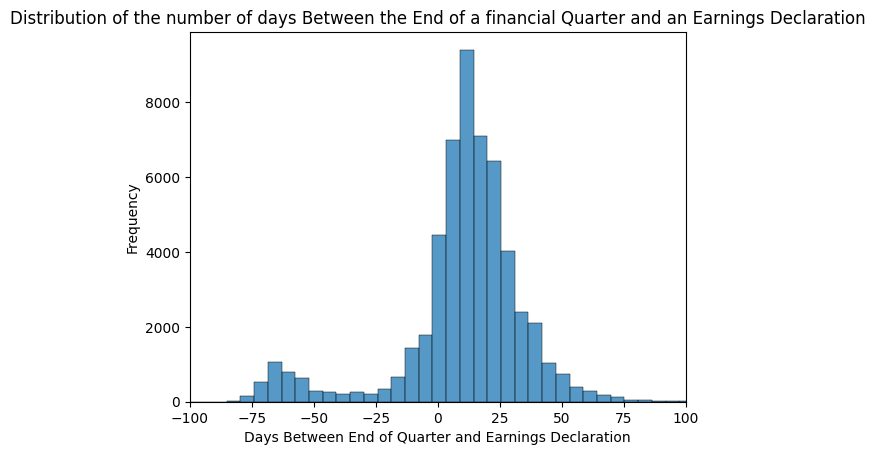

In [127]:
# calculation of number of days between end of quarter and earnings declaration
company_earnings_df['DaysBetweenQuarterAndDeclaration'] = (
    company_earnings_df['EarningsDeclarationDate'] - company_earnings_df['QuarterEndDate']
).dt.days
# calculation of number of days between earnings declaration and earnings announcement 
company_earnings_df['DaysBetweenDeclarationAndAnnouncement'] = (
    company_earnings_df['EarningsAnnouncementDate'] - company_earnings_df['EarningsDeclarationDate']
).dt.days

# histogram displaying distribution of days between end of quarter and earnings declaration
num_bins = 100
sns.histplot(data=company_earnings_df, x="DaysBetweenQuarterAndDeclaration", bins=num_bins)
plt.xlabel("Days Between End of Quarter and Earnings Declaration")
plt.xlim(-100,100)
plt.ylabel("Frequency")
plt.title("Distribution of the number of days Between the End of a financial Quarter and an Earnings Declaration")
plt.show()

We can see from this histogram that the distribution follows a normal distribution pretty uniformly peaking at roughly 10 days after the end of the quarter. Lets take a more in depth look at this by generating a normal distribution.

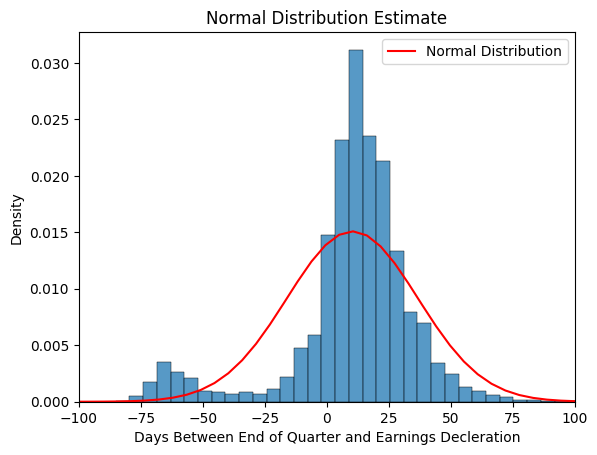

estimated mean and standard deviation for amount of days between the end of a quarter and an earnings declaration, Mean:10.33477408838666 std dev: 26.44610029778322


In [128]:
from scipy.stats import norm
#Histogram displaying normal distribution estimate of data
sns.histplot(data=company_earnings_df, x='DaysBetweenQuarterAndDeclaration', stat='density', bins=num_bins)

#calculating mean, std and generating a distribution
mean = company_earnings_df['DaysBetweenQuarterAndDeclaration'].mean()
std_dev = company_earnings_df['DaysBetweenQuarterAndDeclaration'].std()
x = np.linspace(company_earnings_df['DaysBetweenQuarterAndDeclaration'].min(), company_earnings_df['DaysBetweenQuarterAndDeclaration'].max(), 100)


# overlay normal distribution
plt.plot(x, norm.pdf(x, mean, std_dev), label="Normal Distribution", color="red")
plt.xlabel("Days Between End of Quarter and Earnings Decleration")
plt.ylabel("Density")
plt.xlim(-100,100)
plt.title("Normal Distribution Estimate")
plt.legend()
plt.show()

print(f"estimated mean and standard deviation for amount of days between the end of a quarter and an earnings declaration, Mean:{mean} std dev: {std_dev}")

We see from this that 50% of declarations occur within 10 days of the end of a fiscal quarter but we also see a large standard deviation meaning the data is spread out more widely then we'd expect. This is likely to the hump seen in the left side of the graph showing that a non negligable portion of declarations actually occur between 75-50 days before the end of a quarter, a very suprising result that we did not expect. Let's try and assertain why exactly this hump exists, is there a group of companies that tend to file early? or a time period/quarter where companies file earlier then expected?

In [129]:
# grab the subset of declarations occuring before the end of the quarter 
early_declarations_df = company_earnings_df[company_earnings_df['DaysBetweenQuarterAndDeclaration'] < 0]
early_file_ratio = (early_declarations_df['USym'].nunique()) / (company_earnings_df['USym'].nunique())
print(f"percentage of companies in database who have filed early at least once: {early_file_ratio}")

percentage of companies in database who have filed early at least once: 0.41579448144624165


it looks like a larger amount of companies then expected have declared earnings early, with over 40% of total companies in the dataset declaring their earnings before the quarter ends at least once, so this isn't a practice that a couple outlier companies have, lets try and see if it had something to do with any of the economic downturns over the past 10 years by seeing in what years these early declarations were the most common

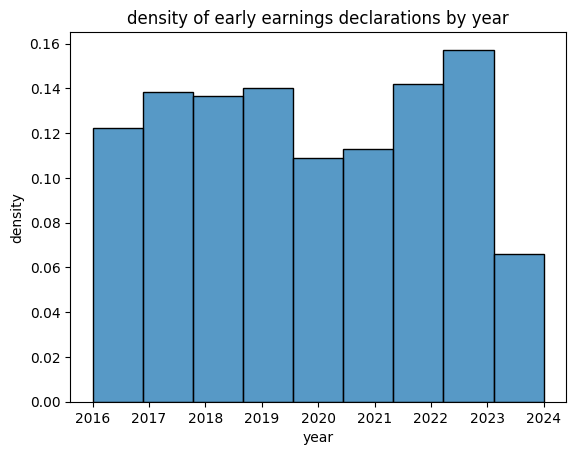

In [131]:
num_bins = 9
sns.histplot(data=early_declarations_df, x="FiscalYear", bins=num_bins, stat="density")
plt.xlabel("year")
plt.ylabel("density")
plt.title("density of early earnings declarations by year")
plt.show()

There doesn't seem to be much variation in early earnings declarations by year, as every year has at least 10% of the early filings, (except for 2024 which is on track to reach 10%) in fact the years with the most volatility and economic downturn (2020, 2021 due to the covid pandemic) seem to have the least amount of early declarations, lets check if early declarations occur more in specific quarters or if the general baseline of earnings declarations only occuring after quarter end dates is incorrect.

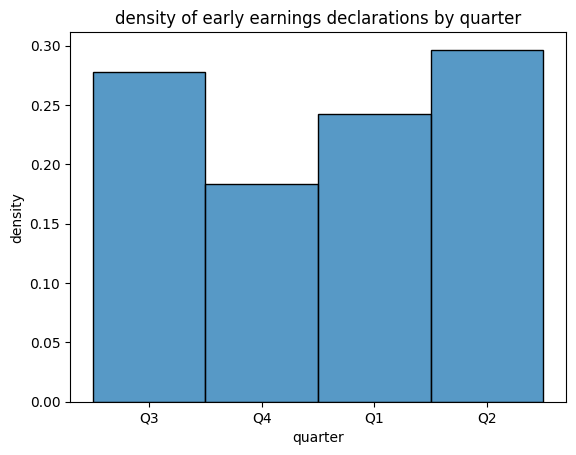

In [132]:
num_bins = 4
sns.histplot(data=early_declarations_df, x="Quarter", bins=num_bins, stat='density')
plt.xlabel('quarter')
plt.ylabel('density')
plt.title('density of early earnings declarations by quarter')
plt.show()


it seems like this trend holds amongst all years, quarters, and companies meaning we can confirm that the outlier is indeed significant and we can expect a small but still substantial amount of earnings declarations to be reported between 50-75 days before the end of the quarter. followed by almost all other declarations occuring between 5-15 days after the end of the quarter